In [3]:
%matplotlib inline
import requests
from PIL import Image, ImageDraw,ImageFont
import face_recognition
import pandas as pd
import numpy as np
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


image_dir = "C:/Users/boyerm/_Capstone 3 Final/pics2"


# Hair Style Recommendation Method based on Automated Face Shape Detection

Marrnie Boyer, ThinkFul final capstone - 12/2017

With this project, I will attempt to address this challenge by developing a hairstyle recommendation system that identifies the user’s face shape and recommends the most flattering hair style. My approach will be to first build a facial classifier that will determine whether the user’s face is long, round, oval, heart- or square-shaped.  Based on the classification, the model will recommend appealing hairstyles. The recommendation system will continually update utilizing user input on their most and least desired hair styles. 

I envision that this model would be implemented inside an app that could be integrated into a hair salon/hair care company's current app.  Ideally, it would be part of an appointment scheduling app that prompts the user to take a selfie before their appointment, review and rate recommended hair styles, and save their favorites to share with their stylist (who would have access to the styles before/during the appointment).  

First, I want everyone to know what "face shape" means and why it is important.  For this project, I am focusing on women's faces and hair styles, although this concept applies to men too.  Face shape is often used to help women determine how to style their hair, choose their eye glasses and apply their make up.  Face shape detection is subjective and this project attempts to provide a more quantitative approach.
Good Housekeeping recognizes five main face shapes.  Below are examples of each of these shapes.

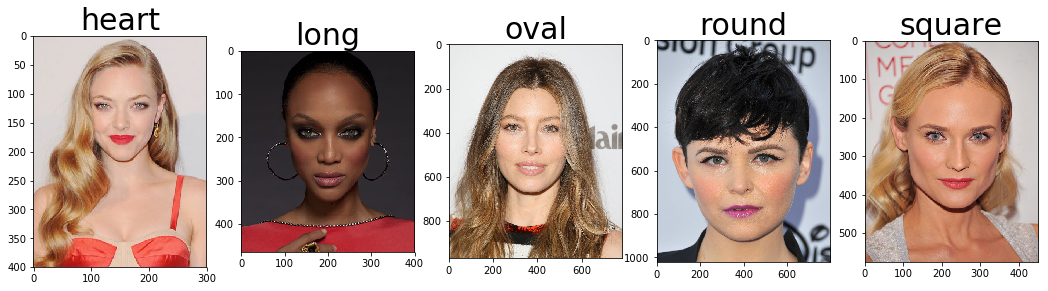

In [2]:
plt.figure(figsize = (18,18))

examples = ['C:/Users/boyerm/_Capstone 3 Final/pics/heart/amanda seyfried 10.jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/long/Tyra Banks (4).jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/oval/Jessica Biel (20).jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/round/Ginnifer Goodwin (35).jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/square/Diane Kruger (1).jpg']

names = ['heart','long','oval','round','square']
            
for i in range(0,len(examples)):
    plt.subplot(2,5,i+1)
    img = Image.open(examples[i])
    draw = ImageDraw.Draw(img)
    plt.imshow(img)
    plt.title(names[i],fontsize= 30)
    img.close()

As you review these images, you can see that the faces do differ in structure in various ways:

The heart-shaped face is characterized by wider cheekbones that tapers down to a narrow chin.

The long face is, well, long and very narrow.

The oval face is similar to the long face but fuller than the long face.

The round face is distinct, it's a much shorter and wider shape.

The square-shape face is charcterized by a strong jaw.

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Dataset Collection

In order to develop a set of images labeled with the correct face shape, I turned to the experts in the fashion and style industry. I reviewed 22 websites and 234 celebrities.  Of these, 33 celebrities had a unanimous classification from 3 or more sites (65 from 2 or more). 49 other celebrities had one or two conflicting classifications but had strong consensus towards a face shape with which I could use to classify.  As a result, 74 celebrities were utilized in the analysis.  There were ~160 celebrities I did not include as they either had too few citations or several conflicts. Because the topic is already subjective, I wanted to ensure I had a level of rigor to labeling my dataset to improve the outcomes.  More labeled data would be ideal and would be an area of future enhancement.

Please see website_list.csv, All_Celebrities.csv, Celebrities_Used.csv for the full list of sites and celebrities considered and used in this project.

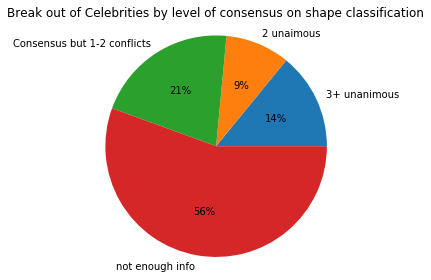

In [4]:
celeb_count = [33,22,49,130]
labels = ['3+ unanimous','2 unaimous','Consensus but 1-2 conflicts','not enough info']
patches = plt.pie(celeb_count, labels = labels,autopct='%1.f%%')
plt.axis('equal')
plt.title('Break out of Celebrities by level of consensus on shape classification')
plt.tight_layout()
plt.show()

Of the five face shapes, square faced celebrities were the most agreed upon, with 74% of those celebrities having a unanimous consensus on their shape. Round was second highest at 70%.  

Because the classification of face shape is subjective, this will impact the potential accuracy of the model, however, this model attempts to develop an approach to resolving conflict over face shape and providing more stringent guidelines on the definitions.  

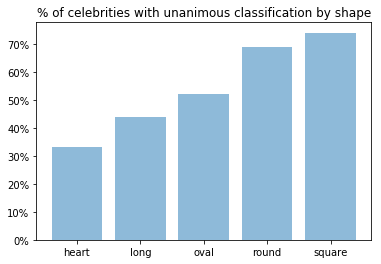

In [5]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)


percent_unanim = [33,44,52,69,74]
shapes = ['heart','long','oval','round','square']
y_pos = np.arange(len(shapes))

plt.bar(y_pos, percent_unanim, align='center', alpha=0.5)
plt.xticks(y_pos, shapes)
plt.title('% of celebrities with unanimous classification by shape')
 
plt.show()

Square faces have the most consensus which allowed for me to use the most celebrities with square faces.  

In order to collect the image dataset, a script was run to download 100 images from Google Images for each celebrity. The images were manually reviewed to ensure they will work for this project (I quickly confirmed that it was an image of celebrity's face and generally face-forward). The appropriate images were saved out to folders with the name of the classified shape. My dataset consisted of ~1500 images for 74 celebrities.

In [ ]:
# Below is the reference to the python script (I don't recommend running as it 
# will download images from Google!)

#%run -i scrape_google_images.py

The images utilized for this project are available in the PICS folder on my github. In order to run this project, download the PICS folder to the same folder where you have saved this notebook.

The two pie charts below provide a breakdown of the % of images by face shape and the % of celebrities with each face shape in my dataset. You can see that the face shapes were similarly represented in the dataset. 

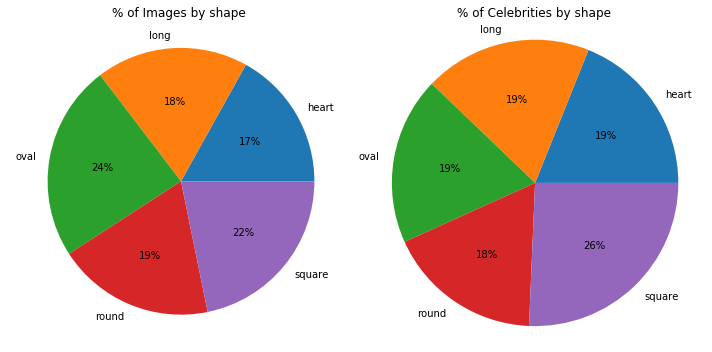

In [12]:
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1)
shape_count = data.groupby('classified_shape').count()['0']
labels = shape_count.index
patches = plt.pie(shape_count,autopct='%1.f%%', labels = labels)
plt.axis('equal')
plt.title('% of Images by shape')
plt.tight_layout()

plt.subplot(1,2,2)
celebritites_by_shape = [14,14,14,13,19]
labels = ['heart','long','oval','round','square']

patches = plt.pie(celebritites_by_shape,autopct='%1.f%%', labels = labels)
plt.axis('equal')
plt.title('% of Celebrities by shape')
plt.tight_layout()
plt.show()

# Processing Images

An extraordinary amount of work has been done around computer vision such that a library called `face_recognition` exists to locate the features of a human face.  This library was built using dlib’s state-of-the-art face recognition built with deep learning. 

### Feature Extraction

Below is a map of the facial feature map which generates 68 unique points.

<img src="face_points.jpg" alt="face_points" style="width: 600px;"/>

Note that the face_recognition package does not provide a top point of the head, so on the basis of a few observations, I determined the half-way point on the face is point 29, so I used double the distance between the chin and point 29 to determine face height. Another available method would be to use the change color (from skin to hair) as the top of the face, however, this would require that the photos not have any bangs and may not work for all skin/hair color combinations. 

From these face points, I developed 23 additional features.  For the first 16 features, I calculated the angles between the chin point (point 9) and each of the jaw line points (1-8, 10-17).  Additionally, I added face width (the distance from point 1 to point 17), face height (described above), the ratio between them, the jaw width (distance between points 7 and 11), the jaw width to face width ratio, the mid-jaw width (distance between points 5 and 13), and the mid-jaw width to jaw width ratio.

### Processing

In order to process over 1500 images, I developed a function that processes through the folders that I created in the data collection stage. It utilizes the folder name to hold the classification. This allows for future and on-going development.  Additional celebrities, images and face shapes could be added to this process without the need for updating the functions.

The function in the py file (make_face_df2) is the primary function for feature development. For each image, the function identifies each of the facial features utilizing face_recognition. Using the eyes as the pivot point, it rotates the face so it is facing forward. It also crops the photos so that every image has the same dimensions and the eyes are locked into the same place on each photo. The function identifies the location of the facial features using the new aligned/cropped image. 

The function then calculates the features described above: the angles between the chin point (9) and all of the lower facial features (1 - 8, 10 - 17), Face Width, Face Height, the ratio of height to face,	Jaw width, the ratio of the jaw to face width, the mid-jaw width and the mid-jaw to face width.

Note that because I cropped and aligned each face to the same point, we can now compare lengths as an absolute number.  If I had not adjusted this, those numbers would be meaningless because all of the photos are at a different distance from the camera, meaning a longer number for the length may not mean that the face was longer but rather the face was close to the camera. This will be important for the logic in my comparisons below.

All of these points and features are then placed into a dataframe to start analyzing with various models.

In [4]:
df = pd.DataFrame(columns = ['0','1','2','3','4','5','6','7','8','9','10','11',	'12',	'13',	'14',	'15',	'16','17',
                             '18',	'19',	'20',	'21',	'22',	'23',	'24','25',	'26',	'27',	'28',	'29',
                             '30',	'31',	'32',	'33',	'34',	'35',	'36',	'37',	'38',	'39',	'40',	'41',
                             '42',	'43',	'44',	'45',	'46',	'47',	'48',	'49',	'50',	'51',	'52',	'53',
                             '54',	'55',	'56',	'57',	'58',	'59',	'60',	'61',	'62',	'63',	'64',	'65',
                             '66',	'67',	'68',	'69',	'70',	'71',	'72',	'73',	'74',	'75',	'76',	'77',
                             '78',	'79',	'80',	'81',	'82',	'83',	'84',	'85',	'86',	'87',	'88',	'89',
                             '90',	'91',	'92',	'93',	'94',	'95',	'96',	'97',	'98',	'99',	'100',	'101',
                             '102',	'103',	'104',	'105',	'106',	'107',	'108',	'109',	'110',	'111',	'112',	'113',
                             '114',	'115',	'116',	'117',	'118',	'119',	'120',	'121',	'122',	'123',	'124',	'125',
                             '126',	'127',	'128',	'129',	'130',	'131',	'132',	'133',	'134',	'135',	'136',	'137',
                             '138',	'139',	'140',	'141',	'142',	'143','A1','A2','A3','A4','A5','A6','A7','A8','A9',
                            'A10','A11','A12','A13','A14','A15','A16','Width','Height','H_W_Ratio','Jaw_width','J_F_Ratio',
                             'MJ_width','MJ_J_width'])

In [10]:
%run -i functions_only.py    # This calls my main function (make_face_df2, described above)

In [11]:
%run -i functions_only-save.py    # This calls my 2nd  function  for recommender below

The code below will run the main function on all of the photos in the above directory. This creates a neat dataset that contains the 68 coordinates for face landmarks, the calculated lengths and ratios and matches that with the image name and classified shape (which is extracted from the folder name in the code below).

In [ ]:
# make df to store name of shape
      
data = pd.DataFrame()
data.reset_index
shape_df = pd.DataFrame(columns = ['filenum','filename','classified_shape'])
shape_array = []
def store_features_and_classification():
    filenum = -1
    sub_dir = [q for q in pathlib.Path(image_dir).iterdir() if q.is_dir()]
    start_j = 0
    end_j = len(sub_dir)

    for j in range(start_j, end_j):
        images_dir = [p for p in pathlib.Path(sub_dir[j]).iterdir() if p.is_file()]

        for p in pathlib.Path(sub_dir[j]).iterdir():
            print(p)

            shape_array= []
            if 1 == 1:
                    face_file_name = os.path.basename(p)
                    classified_face_shape = os.path.basename(os.path.dirname(p)) 
                    filenum += 1
                    make_face_df2(p,filenum)
                    shape_array.append(filenum)
                    shape_array.append(face_file_name)  
                    shape_array.append(classified_face_shape)
                    shape_df.loc[filenum] = np.array(shape_array)
            
            
store_features_and_classification()  
data = pd.concat([df, shape_df], axis=1)

In [ ]:
# Add all faces with shape to a DATA file for model
data.to_csv('all_features5.csv')

In [ ]:
## You can use this only if the data is already in a DF so you don't have to keep running it over and over:

In [5]:
# load data file
# start here
data = pd.read_csv('all_features5.csv',index_col = None)
data = data.drop('Unnamed: 0',axis = 1)
data.shape

(1516, 170)

# Visualizations

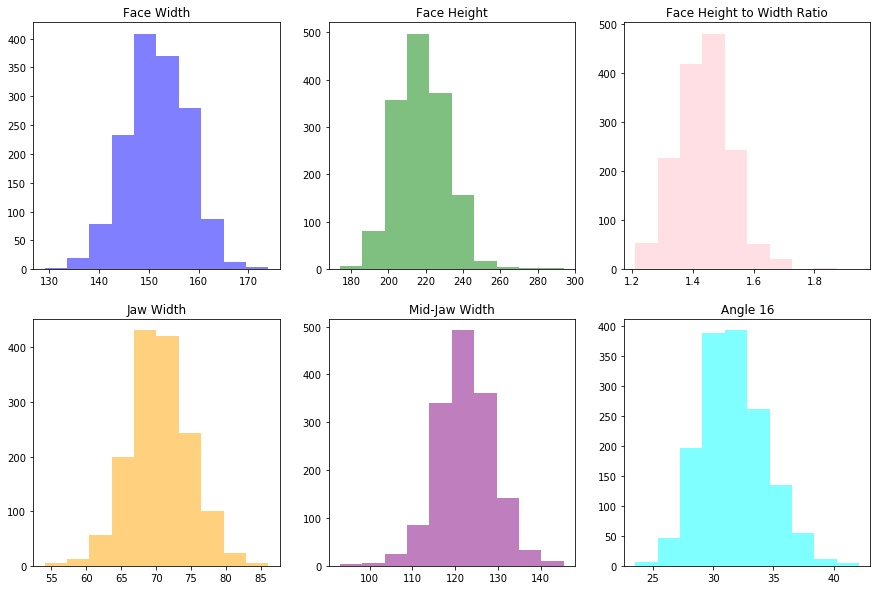

In [11]:
xclean = data.dropna(axis=0, how='any')
plt.figure(figsize=(15,10)) 

plt.subplot(2,3,1)
plt.hist(xclean['Width'], 10, facecolor='blue', alpha=0.5)
plt.title('Face Width')

plt.subplot(2,3,2)
plt.hist(xclean['Height'], 10, facecolor='green', alpha=0.5)
plt.title('Face Height')

plt.subplot(2,3,3)
plt.hist(xclean['H_W_Ratio'], 10, facecolor='pink', alpha=0.5)
plt.title('Face Height to Width Ratio')

plt.subplot(2,3,4)
plt.hist(xclean['Jaw_width'], 10, facecolor='orange', alpha=0.5)
plt.title('Jaw Width')

plt.subplot(2,3,5)
plt.hist(xclean['MJ_width'], 10, facecolor='purple', alpha=0.5)
plt.title('Mid-Jaw Width')

plt.subplot(2,3,6)
plt.hist(xclean['A16'], 10, facecolor='aqua', alpha=0.5)
plt.title('Angle 16')

plt.show()

The attributes here appear to be normally distributed. Now I want to look at the distribution by face shape and what may make them different.

In [13]:
from scipy import stats

S1 = []
S2 = []
S1S2 = []
p_value = []
t_tests = pd.DataFrame() 
labels = ['heart','long','oval','round','square']
for i in range(0,4):
    for j in range(0,4):
        t = (stats.ttest_ind(xclean[xclean.classified_shape == labels[i] ].Width, xclean[xclean.classified_shape == labels[j+1]].Width))
        p_value.append(t.pvalue)
        S1.append(labels[i])
        S2.append(labels[j+1])   
t_tests['S1'] = S1
t_tests['S2'] = S2
t_tests["test"] = t_tests["S1"].map(str) + ':' + t_tests["S2"]
t_tests['p_value'] = p_value

t_tests = t_tests[t_tests.S1 != t_tests.S2]

In [14]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'green' if val < 0.05 else 'black'
    return 'color: %s' % color

s = t_tests.style.applymap(color_negative_red,subset=pd.IndexSlice[:, ['p_value']])
s

,S1,S2,test,p_value
0,heart,long,heart:long,3.00102e-05
1,heart,oval,heart:oval,0.680885
2,heart,round,heart:round,1.05205e-05
3,heart,square,heart:square,0.092465
5,long,oval,long:oval,4.76707e-06
6,long,round,long:round,5.26608e-17
7,long,square,long:square,0.0156144
8,oval,long,oval:long,4.76707e-06
10,oval,round,oval:round,4.876e-05
11,oval,square,oval:square,0.031635


Based on these t-test p-values, we can reject the null hypothesis for the pairs in green font (using p < 0.05):

Heart & Long faces
Heart & Round faces
Long & Oval faces
Long & Round faces
Long & Square faces
Oval & Round faces
Oval & Square faces
Round & Square faces

We cannot reject the null hypothesis for Heart & Oval (p value = 0.68) and Heart & Square (p value = 0.09)

To illustrate the tests above, below is one plot with a pair that is NOT significantly significantly different and the second one is.


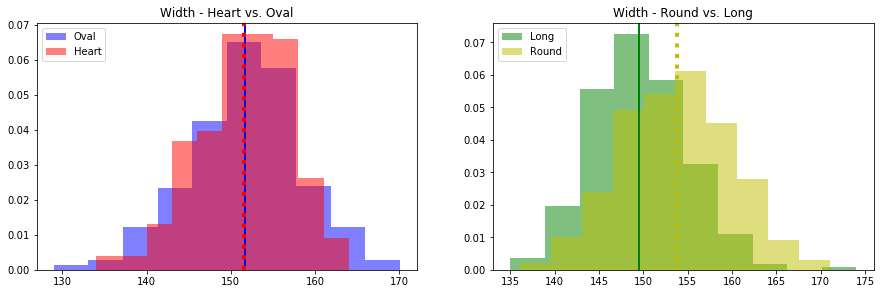

In [15]:

# Face width histograms; purposely normed because of varying sample sizes.

HW = xclean[xclean['classified_shape']=="heart"] 
OW = xclean[xclean['classified_shape']=="oval"] 
LW = xclean[xclean['classified_shape']=="long"] 
RW = xclean[xclean['classified_shape']=="round"] 

plt.figure(figsize=(15,10)) 

plt.subplot(2,2,1)
plt.hist(OW['Width'],label = 'Oval',alpha = 0.5, color = 'b',normed = True)
plt.hist(HW['Width'],label = 'Heart',alpha = 0.5, color = 'r',normed = True)
plt.axvline(OW['Width'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(HW['Width'].mean(), color='r', linestyle='dotted', linewidth=4)
plt.title('Width - Heart vs. Oval')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.hist(LW['Width'],label = 'Long',alpha = 0.5, color = 'g',normed = True)
plt.hist(RW['Width'],label = 'Round',alpha = 0.5, color = 'y',normed = True)
plt.axvline(LW['Width'].mean(), color='g', linestyle='solid', linewidth=2)
plt.axvline(RW['Width'].mean(), color='y', linestyle='dotted', linewidth=4)
plt.legend(loc='upper left')
plt.title('Width - Round vs. Long')

plt.show()

In the first graph where the p >= 0.05, you can see how close the means are for oval- and heart-shaped faces' width and their distributions overlap significantly. Based on the first 5 images displayed at the top of the notebook, it should not be a surprise that the oval- and heart-shaped face width do not differ significantly.  On the other hand, the width for long and round faces are signficantly different (this seems obvious based on their naming).  The mean for round is much higher and the entire distribution is shifted towards wider face dimensions.

Visualizing all of these comparisons for several metrics would be pretty cluttered, so I have created box plots that allow you to quickly review the distributions, means and medians for key features from the dataset.

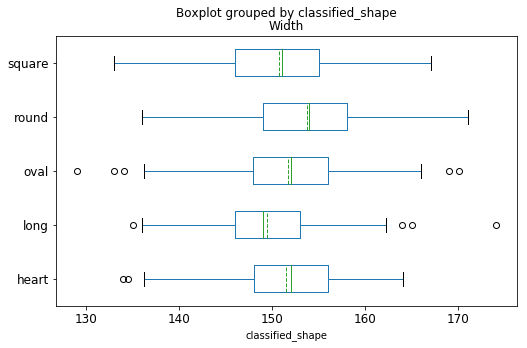

In [16]:
data.boxplot(column='Width', by='classified_shape',vert=False, ax=None, fontsize=12, rot=0, grid=False, figsize=(8,5), 
             meanline = True, showmeans = True,
                  layout=None, return_type=None)
plt.show()

Above, you will find a graph that provides the median (solid line), mean (dotted), quartiles and range of the facial widths (defined as the difference between point 1 and point 17, essentially, ear-to-ear) by facial shape.  As expected, round faces have the largest facial width median, mean and max. Long faces are characterized by having the most narrow face. Just like the histogram above demonstrates, heart & oval are very similar while long and round are the most different.

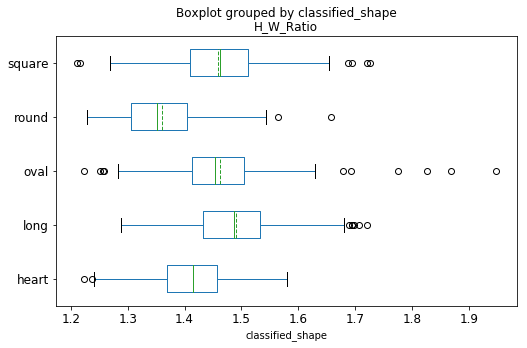

In [17]:
# H_W_Ratio

data.boxplot(column='H_W_Ratio', by='classified_shape',vert=False, ax=None, fontsize=12, rot=0, grid=False, figsize=(8,5), 
                  layout=None, return_type=None, meanline = True, showmeans = True)
plt.show()

The box plot above illustrates the face height to width ratio.  The round face shape has the lowest height to width ratio which aligns with expectations.    Based on the naming, one may assume square faces would have a lower (close to 1) height to width ratio but that is not the case. I believe this is because the 'square' moniker is more about the woman's jaw shape than the overall face dimensions.  The oval face has the most variability for the height to width ratio attribute.

For width, the heart and oval were very similar, but you can see that for the ratio of height to width, the heart- and oval-shaped faces begin to differentiate.  Oval-shaped faces have a higher height to width ratio than heart (i.e., they are longer than heart-shaped faces).

Based on my observation, face shapes really begin to vary near the mouth/chin.  Therefore, I calculated two new features regarding the width of the jaw at different locations.
The Jaw Width is defined as the distance between points 7 and 11. The Mid-jaw width is defined as the distance between the 5 and 13 points. I then calculated the ratio of those two widths.

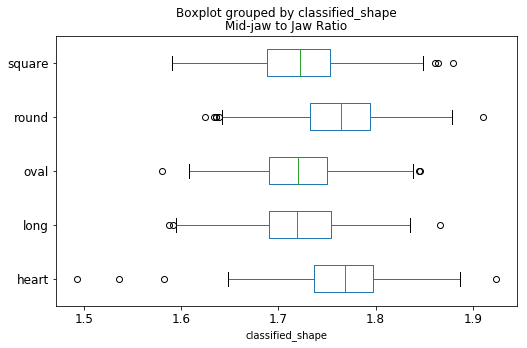

In [18]:
data.boxplot(column='MJ_J_width', by='classified_shape',vert=False, ax=None, fontsize=12, rot=0, grid=False, figsize=(8,5), 
                  layout=None, return_type=None)
plt.title('Mid-jaw to Jaw Ratio')
plt.show()
#note this is the Mid-jaw to Jaw width ratio...(typo)

This ratio allows us to observe the narrowing between the mid jaw and jaw for the heart shaped faces, evidenced by the higher ratio.  Once again, you can see that heart and oval differ.  Heart-shaped faces are characterized by narrow chins which means that the mid-jaw to jaw ratio is higher (i.e., the mid-jaw is proportionally larger vs. the lower jaw/chin area). 

These graphs reinforce to me that the features I have extracted and generated from my dataset are going to be useful in a model as differences between the metrics are illustrated by the various face shapes.  

## Make smiley

In [7]:
face_pt_avg = data.groupby("classified_shape").mean()

face_pt_avg = face_pt_avg.drop(['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12',
                                'A13','A14','A15','A16','Width','Height','H_W_Ratio','Jaw_width','J_F_Ratio',
                                'MJ_width','MJ_J_width'],axis = 1)


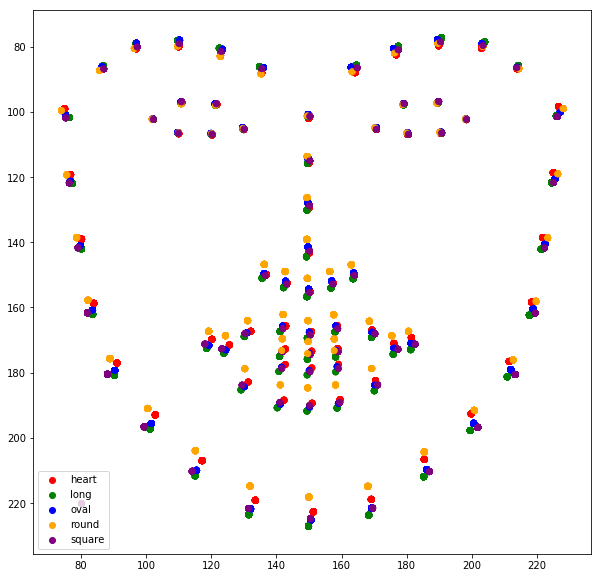

In [18]:
feature_ct = (face_pt_avg.shape[1])/2
feature_ct = int(feature_ct)
colors = ('red','green','blue','orange','purple')
labels =  ('heart','long','oval','round','square')

plt.figure(figsize = (10,10))


def make_smiley(x,rs,re):
    
    x_arr = []
    y_arr = []

    for ff in range(0, feature_ct):
        fpav = face_pt_avg.values
        x_coord = fpav[rs:re,x:x+1]
        y_coord = fpav[rs:re,x+1:x+2]
        x_arr.append(x_coord)
        y_arr.append(y_coord)
        x += 2

        plt.scatter(x_arr,y_arr,c=colors) 
        
    for L in range(len(labels)):
        plt.scatter(80,220,c=colors[L],label = labels[L])
        plt.legend(loc=3)
        
    plt.gca().invert_yaxis()
    plt.show()


x = 0
rs = 0
re = 6
make_smiley(x,rs,re) 

This graph maps the coordinates of the average of each face shape.  This is my favorite visualization because it is simple but illustrates important differences in the shapes.  The dots all overlap at the eyes because my make_face_df2 function locks the eyes to a position to standardize the dimensions.  However, from there, you can see how the face shapes begin the differ.  Round faces (orange) are much shorter on average. The green dots are at the lowest point on the graph and this represents the long faces - very intuitive. The narrow chin of the heart-shape face (appropriately colored red) is also clear.

## Face Overlays

The following images also illustrate how the crop/align/rotate process allows for the faces to be very consistent in their position within the frame. This was an important step because the photos were taken by all different photographers, at different times and from multiple positions.  Without this step to standardize, there was a lot more noise in the derived and calculated  features.  The first 5 images are all of the pictures of the same celebrity.  The 6th image is all of the square-shaped face celebrities.  

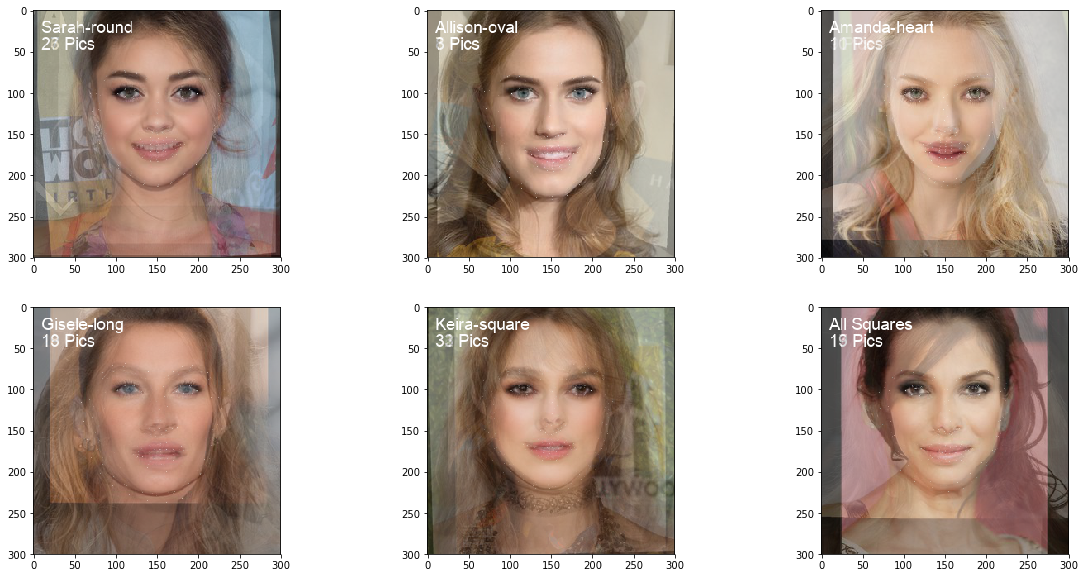

In [22]:
%run -i Plot_Images.py 

# Evaluate models

Based the limited amount of data for training, it is not unexpected that the models performance will show both over-training and lower accuracy than if I had thousands or millions of sample images.  There are no guidelines or real ground-truth for classification of facial shapes.  A pre-labeled dataset does not exist.  This is what makes this project interesting but challenging.  Keeping this in mind, I worked to develop the best model possible.

## Modeling Pipeline

The process I utilized to build my model is to begin with capturing the data as described above, then I scaled the data by removing the mean and scaling to unit variance.  This is done so that each feature contributes approximately proportionately to the model.  I then generate new features as described above.  I attempted to extract features using PCA but that process did not significantly improve the speed and/or results of my models. Although PCA was able to slightly improve overfitting.

The scaled inputs were split into train/test and then proessed through the models below.

## Model Comparisons

Below, I have outlined all of the models I attempted.  Refer to the notebook below for the modeling implementation and validation.  Below the graph, I've discussed the reasons I attempted these models, the hyperparameters I chose as well as the decision support to use my selected model.

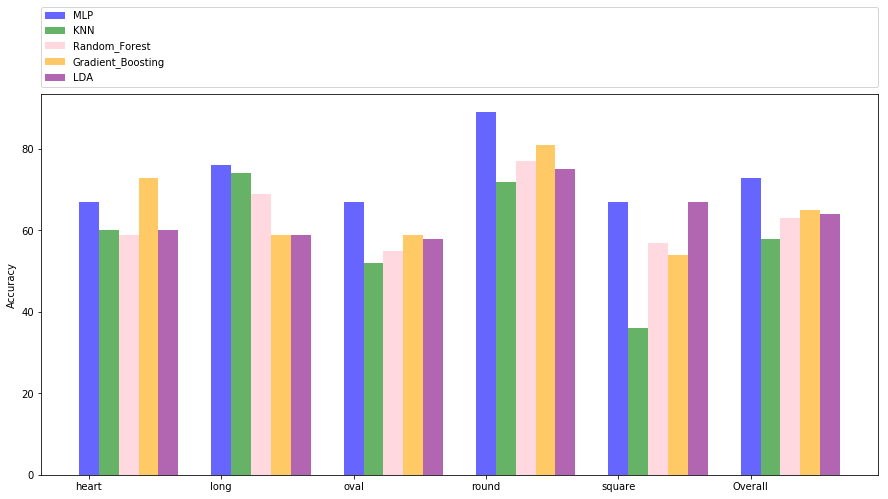

In [38]:
% run -i model_comparisons.py

### Why I chose this set of models:

I chose KNN because one of its most attractive features is that is simple to understand and easy to implement, especially for multi-class problems like mine. Although it doesn't apply to my needs here, KNN is also a very flexible model and does not require a certain underlying distribution of the data. After a few runs, KNN tends to perform the worst of my models.

I also attempted a Random Forest Classifier. As an ensemble predictor, I believe that it would be useful to form a strong model using the learnings from weaker models.  A disadvantage of the RF model is that it can overfit the data, as you will see here. I attempted to tune the hyperparameters to help the model ignore some of the noise in the small sample size (by changing the leaf size, for example).  The RFC is fast (even with hundreds of iterations) which makes it a good choice as well.

In each iteration of RFC, the classifiers are trained independently.  However, with Gradient Boosting, it builds on weak classifiers so that the next classifier is trained to improve the already trained ones.  This may explain why GB performs better than RFC. The GB model took the longest to run, especially when certain hyperparameters were chosen.

I also tried Linear Discriminant Analysis because I wanted to compare the performance of a linear model. LDA makes predictions by estimating each probability that each input belongs to each class. The class that gets the highest probability is the output class and a prediction is made for that input. LDA has some limitations; it requires normalized data (which I have) with the same variance (which I did).  It also can be impacted by outlier data, which exists in my dataset so may have impacted performance here.

Finally, I wanted to use a neural network because they are powerful and flexible with the ability to capture nonlinear and complex underlying characteristics of a dataset with a high degree of accuracy.  Neural networks boost to feed the results from one part of the model into the next part, allowing it to learn more as data flows through the layers.  The disadvantage is that because NN require large datasets, the model I built has an overfitting problem.  

For each, I spent a lot of time fine tuning the hyperparameters. After researching which hyperparameters were available in each model, I weighed the priority of tuning these over others to reduce unnecessary time spent on this exercise.  At first through trial and error (if I change this hyperparameter, does the model's performance improve, decline or stay the same), then utilizing grid search and random search, I was able to find the "best" hyperparameters for my models.

### Hyperparameters I tried 
#### MLP
hidden_layer_sizes: this is the most important hyperparameter so I used an iterative approach within the solver to find the best number and size of layers. Fine tuning the layers led to better and better results. 4 layers worked better than 5.

max_iter: 100 - I tried 100, 200, 500 and it always selected 100 so I locked that down to save time later.

learning_rate_init: 0.01 (any smaller and the model would not converge)

#### KNN
For the KNN Model, I tuned the hyperparameters of K and the weighting.  Because the most goal is to classify the samples correctly, I calculated the misclassification error (MSE) for each K.  I determined K=4 was best through this process. (See models_comparison.py, as there is a line graph representing the MSE). When I changed the default weighting from uniform to weighting by distance, it led to overfitting. 

#### RF

I tuned the RF model using the accuracy score and cross validation scores and mean as my guide. There are an unlimited number of combinations so I tried to focus on the hyperparameters most relevant to the dataset I have and the model I am building.

min_samples_leaf - way overfit because it allows leaf size to be 1; A smaller leaf makes the model more prone to capturing noise in training data.  At default (1), there was significant overfitting; as I increased min_samples_leaf, the scores for both train and test decreased, but for training, there was more decline, reducing overfitting.

n_estimators (The number of trees in the forest.) - higher # takes longer but makes predictions stronger and more stable.

max depth - The maximum depth of the tree. As None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples

min_samples_split - I set to 15 (default is 2) to try to reduce noise from small sample size. At 2, the model was significantly overfit; at 15, less so.

criterion did not make a difference, entropy slightly better and more stable with CV; documentation says there is little difference

max_features: max # of features a tree can use - the best model recommended sqrt (square root of the total number of features in individual run)


I manually toggled  other parameters but found little difference in performance as I changed them.

#### Gradient Boosting
GB models are similar to random forest in terms of the definition of the hyperparameters. There are more hyperparameters to choose when you use GB.

n_estimators: higher # takes longer but makes predictions stronger and more stable. Picked 300.

max_depth: max dept of a tree; used to control over-fitting as higher dept will allow the model to learn specifics relations for a particular sample; randome search for "best" model chose 15.

min_samples_leaf: increasing from default of 1 to 20 increased accuracy again by forcing the model not to overfit so each sample had its own leaf

min_samples_split: worked best at 2 (default)

#### LDA

This model ran a lot more quickly so I used a grid search to find the "best" model.  I had to split the grid search to solvers that allowed shrinkage (lsqr, eigen) and the svd solver which does not.  The hyperparameters I varied were:

SVD Solver:
n_components: the "best" model had 1 component
tol = 0.1

This model had the same performance as the other option with eigen or lsqr solvers (with shrinkage). I tuned the n_components (also 1) and shrinkage (auto was the best).

In model_comparisons.py, I evaluated each model that I built. For each model, I calculated the recall for each face shape as well as the overall model. I chose MLP neural network model because it performed the best in 4 out of 5 shape classifications and overall. I also believe this model will continue to improve performance as more images are added, which will allow the application to scale efficiently.  The Gradient Boosting model  performed similarly to the MLP however, it is a much slower model to run.

The neural network model performed well but I know it would be a much better model with many more input images and celebrities.  All of the models had over-fitting, likely because of the use of the same celebrity in many images.

You will see that I tried to use PCA to reduce the dimensionality of the model but when I tested my models with and without PCA, they did not perform much differently. Since neural networks can efficiently handle many variables, it was not imperative I work diligently on reducing the number of features in the dataset.

### Retraining a CNN Model

I also ventured to retrain an convolutional neural network with Keras to take advantage of its significant accuracy in detecting images. Without the proper equipment (and experience), this proved to be a difficult task.  It serves as a motivator for future development.  The process I utilized was to import the VGG16 CNN from the Keras Application library, then remove its 'top' layer (the 1-1 classification layer), and retrain it on my images and classifications. After 50 epochs, the accuracy was only 35%.  I was later exposed to FloydWeb where I was able to move my Jupyter notebook and dataset to the FloydWeb servers and run off their GPU.  This proved MUCH more efficient, allowing me to run more epochs. However, the improvements were small and the accuracy only increased to about 40%.

I chose VGG16 because it was well documented and easy to implement. That being said, it is NOT state of the art. My desire was to use Inception v3 but I had trouble figuring out how to do the re-training.  These CNN models also require a lot of input data, although documentation related to the retraining of CNN models seem to indicate it can be done with a small dataset. This could be if these are images that the model has already been trained on (dogs, cats, etc) rather than nuanced facial features.

I would be eager to explore these models in the future for use with this or other image recognition projects.

## Supervised Learning - the chosen model

### Set up Test/Train for supervised learning

In [39]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA 

In [40]:
data_clean = data.dropna(axis=0, how='any')
X = data_clean
X = X.drop(['filenum','filename','classified_shape'] , axis = 1)
X_norm = normalize(X)
Y = data_clean['classified_shape']

### Standardize features by removing the mean and scaling to unit variance

In [41]:
scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)

### Split into train/test sets

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.25,
    random_state=1200)

### Apply PCA for dimension reduction

In [67]:
n_components = 18
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [68]:
# #Remove PCA 
X_train_pca = X_train
X_test_pca = X_test

## Neural Network (MLP)

In [69]:
from sklearn.neural_network import MLPClassifier

In [29]:
# DONT NEED TO KEEP Re-RUNNING
import itertools

mlp = MLPClassifier(hidden_layer_sizes=(60,10,60,30), solver='sgd',shuffle  = True, 
                    learning_rate_init=0.01, max_iter = 200,warm_start  = False)

from sklearn.model_selection import RandomizedSearchCV 
param_grid = { 
    'learning_rate_init':[0.01]   # always the best
    ,'hidden_layer_sizes': [x for x in itertools.product((10,20,30,40,50,60,100),repeat=4)]
    ,'max_iter': [100] # always the best
    ,'random_state': [525]
}

random_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, cv= 5, n_iter = 50)
random_search.fit(X_train_pca, Y_train)
print(random_search.best_estimator_)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [70]:
# with best model tuning

best_mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
best_mlp.fit(X_train_pca, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [71]:
print(best_mlp.score(X_train_pca, Y_train))
mlp_score = best_mlp.score(X_test_pca,Y_test)
print(mlp_score)

1.0
0.729946524064


In [72]:
y_pred = best_mlp.predict(X_test_pca)
 
mlp_crosstab = pd.crosstab(Y_test, y_pred, margins=True)
mlp_crosstab

print(classification_report(Y_test,y_pred))

             precision    recall  f1-score   support

      heart       0.70      0.67      0.69        73
       long       0.69      0.76      0.72        58
       oval       0.67      0.67      0.67        92
      round       0.80      0.89      0.84        79
     square       0.80      0.67      0.73        72

avg / total       0.73      0.73      0.73       374



# Run Example:

This section is the implementation of the model itself on a new image.  Select a photo and start the process below.

In [73]:
my_photo = 'jackie.jpg'
n = 2035
make_face_df2_save(my_photo,n)

In [74]:
dfc = df
test_row = dfc.ix[n].values.reshape(1,-1)
test_row = scaler.transform(test_row)  
test_shape = best_mlp.predict(test_row)
print(test_shape)

['oval']


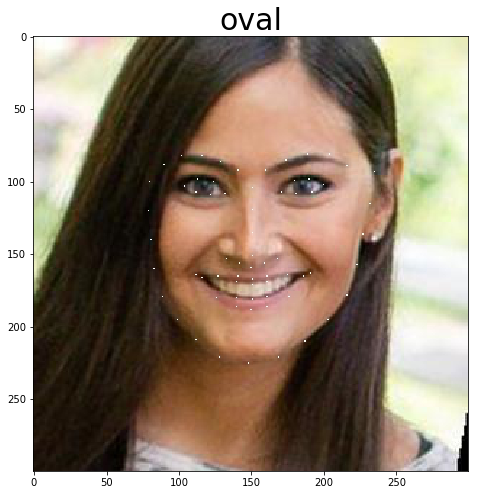

In [75]:
plt.figure(figsize = (8,8))
new_photo = my_photo+'_NEW_rotated_pts.jpg'
img = Image.open(new_photo)
draw = ImageDraw.Draw(img)
plt.title(test_shape[0], fontsize = 30)
plt.imshow(img)
img.close()

In [76]:
dfc

,0,1,2,3,4,5,6,7,8,9,...,A14,A15,A16,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width
2035,80.0,100.0,79.0,120.0,81.0,140.0,83.0,160.0,89.0,179.0,...,41.593556,37.366669,33.388514,155.157984,212.084889,1.366896,75.006666,0.483421,127.003937,1.693235


# Recommender

The recommender python file below contains the code for the recommender which uses as inputs: the face shape classified above, the user's desire for an up-do or not and their hair length.

It returns 6 images of hair styles recommended for their face shape.  The original selection is based on a random number score. However, the user can then provide feedback to the system that indicates their top and bottom preference.  This preference iterates back into the score by adding or removing points from the score.  If the user liked the style, this will increase the priority of the style for the next user and the opposite is true for the user's least favorite style.  This is a rudimentary system but utilized as a basic concept.

The recommender images are a subset of the images I used to train the model.  I reduced to a subset to remove having too many of the same hairstyles, especially from the same celebrity as well as very outdated hair style.

For your review, I have included the score below each photo. You will see that the style you select as your favorite will increase by 5 points in the next iteration and the one you select as your least favorite will lose 5 points (and may fall off your top 6 list). 


There is a lot of opportunity to improve my recommendation system with more time and resources.  A few thoughts that I would explore in the future:

1) A recommendation system that employs colloborative filtering. The CF algorithm works by identifying a set of users with similar past preferences as the target user's. The algorithm recommends N items to the target user based on what the similar people like. In this case, there is no consideration of the items' characteristics themselves.

This recommendation system can be improved by allowing users to set up profiles that collect information that can be used to create these similar sets of users (in addition to their past preferences). This would help the system identify a new user's possibly set of similar users because it provides some information upfront about the user before they begin to rate the items in the system.  I think this would work well for my project because there are additional attributes that may impact someone's choice of hairstyle (other than length and face shape). For example, hair texture, volume, elasticity and color as well as  age and skintone, may impact the user's hair style preference. This could be collected upfront (since it is less likely to change) and people with similar profiles could be utilized for ranking style recommendations.

2) Content-based recommendation system. This algorithm focuses on the features of the items you are recommending.  This requires that the items have some sort of metadata or characteristics. This system recommends items based on their similarity to other items the user has liked.  This is more difficult for this project because the tagging of the hair styles would be relatively manual and subjective.  Unlike movie titles, software, articles, books, etc that have more readily-available metadata, the hair styles would be difficult to utilize a content-based recommendation system.

Ideally, the recommendation system would represent a hybrid of both colloborative filtering and content-based recommendation algorithsm.  The former is easier to implement and can still produce strong results.  My recommendation system below is used to illustrate that the recommendations are based on the algorithm above to find face shape as well as a machine-learning algorithm that begins to learn preferences and store scores for each style (which could be associated to a user within an app or website).  The possibilities are endless and the user would be able to rely upon the algorithms to give them the answers to their pressing style questions with little subjectivity and access to matching themselves up with styles from the best hair stylists in the industry.

In [77]:
% run -i recommender.py

What is your name? marnie
Hello, marnie.
Would you like to see up-dos? (Y/N)n
Is your hair short (shoulder-length shorter) or long?long
Long
oval


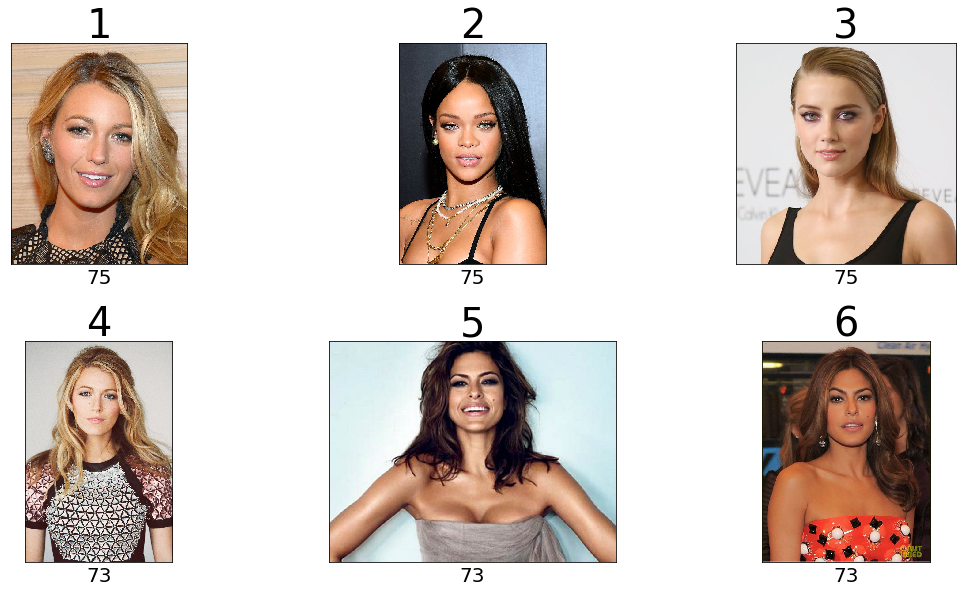

Which style is your favorite? 2
Which file is your least favorite? 6


In [78]:
run_recommender(test_shape[0])

What is your name? marnie
Hello, marnie.
Would you like to see up-dos? (Y/N)n
Is your hair short (shoulder-length shorter) or long?long
Long
oval


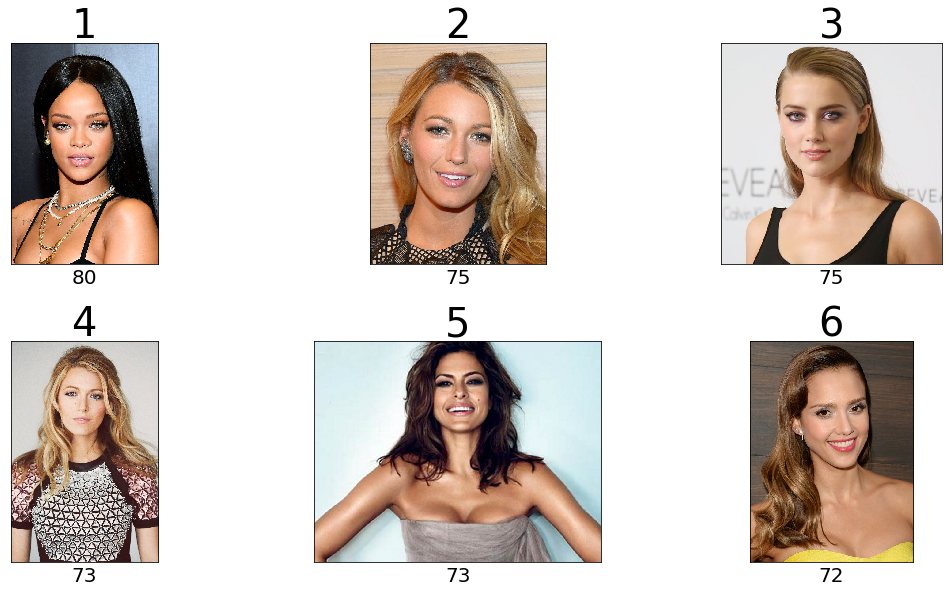

In [ ]:
run_recommender(test_shape[0])

In [ ]:
run_recommender(test_shape)